# **Table of Contents**
* [Explore & Wrangle](#section_20)
* [Assumptions Testing](#section_21)

* [Model Building](#section_22)
    * [LiR](#section_23)
    * [RF](#section_24)
    <br><br>
* [Model Selection](#section_25)
    * [Fitting](#section_26)
    * [Validation](#section_27)
    * [Best Model](#section_28)

In [1]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns

import warnings
warnings.filterwarnings("ignore")


from   sklearn.linear_model     import   LinearRegression
from   sklearn.ensemble         import   RandomForestRegressor

from   sklearn.model_selection  import   train_test_split , KFold , cross_val_score , GridSearchCV
from   sklearn.metrics          import   mean_squared_error

<a id='section_20'></a>
# Part 1 - **Explore & Wrangle**

In [2]:
df  =  pd.read_csv ('datasets/Baseball Wins.csv')

df.sample(5)

,Team,Year,RS,RA,W,OBP,SLG,BA
555,HOU,1979,583,582,89,0.315,0.344,0.256
55,SFG,2001,799,748,90,0.342,0.460,0.266
226,PHI,1993,877,740,97,0.351,0.426,0.274
731,LAD,1971,663,587,89,0.325,0.370,0.266
612,MON,1977,665,736,75,0.318,0.402,0.260


**Target Col -- W**

In [3]:
df.drop ( ['Team','Year'] , axis=1 , inplace=True )

In [4]:
df.shape

(932, 6)

In [5]:
df.isnull().sum()

RS     0
RA     0
W      0
OBP    0
SLG    0
BA     0
dtype: int64

In [7]:
df ['RD']  =  df['RS'] - df['RA']             # runs difference should have good +ve corr with Wins 

In [8]:
df.drop ( ['RS','RA'] , axis=1, inplace=True ) ;

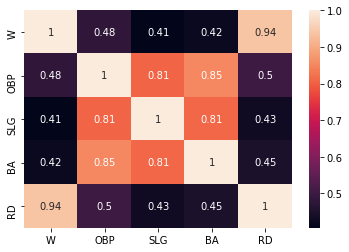

In [9]:
sns.heatmap ( df.corr() , annot=True ) ;

<a id='section_21'></a>
# Part 2 - **Assumption Testing**

In [10]:
import statsmodels.api as sm

y  =  df ['W']
x  =  df.drop ('W', axis=1)
xc =  sm.add_constant(x)

model = sm.OLS(y,xc).fit()

## **1. Normality of residuals**

In [11]:
residuals  =  model.resid

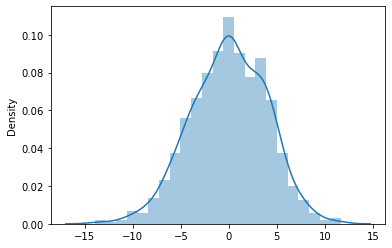

In [12]:
sns.distplot (residuals) ;

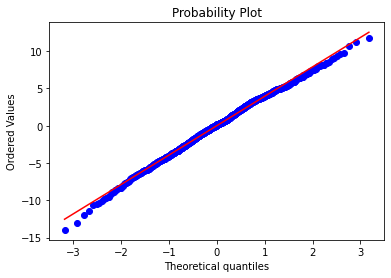

In [13]:
import scipy.stats  as  stats

stats.probplot (residuals ,  plot=plt)
plt.show()

## **2. Low Multi-collinearity**

In [14]:
from   statsmodels.stats.outliers_influence   import   variance_inflation_factor   as   vif

score  =  [   vif (xc.values, i)        for i in  range(xc.shape[1])     ]

MC     =  pd.DataFrame (  {'VIF':score}  ,   index = xc.columns  )

MC.sort_values (by='VIF',ascending=False)

,VIF
const,723.763361
OBP,4.499342
BA,4.377434
SLG,3.383927
RD,1.340143


## **3. Homo-scedasticity**

In [15]:
import statsmodels.stats.api as sms

sms.het_goldfeldquandt ( y=residuals , x=xc )

(1.0316464583475524, 0.36908185182806785, 'increasing')

> Comments :
        
        * H0 : Equal var of residuals
        * H1 : Unequal var of residuals
        * Output : test_statistic , p-value 
> Obs :
        
        * P > alpha
        * Accept Null
        * Homo-scedastic 

## **4. No Auto-correlation**

In [16]:
from  statsmodels.stats.stattools  import  durbin_watson

durbin_watson (residuals)

2.0551200027975827

* Weak auto-corr

## **5. Linearity**

In [17]:
import statsmodels.stats.api  as  sms

sms.diagnostic.linear_rainbow (model)

(1.0325505778884323, 0.3652598531719673)

> Comments :
        
        * H0 : Reg is Linear
        * H1 : Reg is not Linear.
        * Output : test_statistic , p-value 
> Obs :
        
        * P > alpha
        * Accept Null
        * Reg is Linear

<a id='section_22'></a>
# Part 3 - **Model Building**

In [18]:
x  =  df.drop ('W' , axis=1)
y  =  df ['W']

x_train , x_test , y_train , y_test   =   train_test_split (x, y, test_size=0.3, random_state=42)

<a id='section_23'></a>
## **1 - LiR**

In [19]:
lr = LinearRegression()                                       

lr.fit (x_train , y_train)             

LinearRegression()

<a id='section_24'></a>
## **2 - RF**

In [20]:
kf  =  KFold ( n_splits =3 ,  shuffle =True ,  random_state =42 )

In [22]:
RF    =  RandomForestRegressor()

param =  { 'n_estimators':np.arange(1,15) , 'max_depth':np.arange(1,15) }

GS    =  GridSearchCV (RF , param , cv=kf , scoring='r2')

GS.fit (x_train , y_train)

GS.best_params_

{'max_depth': 5, 'n_estimators': 10}

In [23]:
RF = RandomForestRegressor ( n_estimators=10 , max_depth =5 , random_state=0)  

RF.fit (x_train , y_train)

RandomForestRegressor(max_depth=5, n_estimators=10, random_state=0)

<a id='section_25'></a>
# Part 4 - **Model Selection**

In [24]:
models = []

models.append  (( 'LiR'     ,  lr      ))
models.append  (( 'RF'      ,  RF      ))

<a id='section_26'></a>
### **Fitting**

In [25]:
result = []

for i,j in models:

    print(i)
    
    y_train_pred  =  j.predict (x_train)
    y_test_pred   =  j.predict (x_test)
                   
    print  (  ( mean_squared_error  ( y_train , y_train_pred )) **0.5    )                                 
    print  (  ( mean_squared_error  ( y_test  , y_test_pred  )) **0.5    )

LiR
4.013878198733372
3.7606284739466225
RF
3.4040711827594365
4.079583107993635


<a id='section_27'></a>
### **Validation**

In [26]:
result = []

for  i,j  in  models:
    
    score = cross_val_score ( j , x_train , y_train , cv =kf, scoring ='r2' )
    
    result.append ( { 'Name': i   ,   'BE': np.mean(1-score)   ,   'VE': np.std(score,ddof=1)  } )                


table = pd.DataFrame(result)
table

,Name,BE,VE
0,LiR,0.119709,0.014045
1,RF,0.132661,0.016505


<a id='section_28'></a>
### **Best Model**

## *Linear Regression*